<a href="https://colab.research.google.com/github/kamilenovaes/machine-learning-python/blob/main/notebooks/07_svm_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM e Árvores de Decisão para detecção de fraude em cartão de crédito


Treinar **dois modelos de classificação** para identificar transações fraudulentas:

- **Árvore de Decisão (Decision Tree)**
- **Máquina de Vetores de Suporte (SVM)**

A ideia é aprender o fluxo completo: carregar dados → preparar features → treinar modelos → avaliar com **ROC-AUC**.


## 🎯 Objetivos

- Fazer pré-processamento básico de dados em Python
- Modelar um problema de **classificação binária** com `scikit-learn`
- Treinar modelos de **Decision Tree** e **SVM**
- Avaliar a qualidade do modelo com **ROC-AUC**


## 📘 Contexto do problema

Uma transação pode ser:

- **0**: legítima  
- **1**: fraude  

Isso é um problema de **classificação binária**.

⚠️ **Desbalanceamento:** normalmente há **muito mais transações legítimas do que fraudes**.  
Se você treinar “do jeito padrão”, o modelo pode aprender a sempre prever 0 e ainda assim parecer “bom” em acurácia.  
Por isso, vamos usar pesos de classe/amostras e avaliar com **ROC-AUC**.


## 1. Importar bibliotecas


In [ ]:
# (Opcional)
# !pip install pandas==2.2.3
# !pip install scikit-learn==1.6.0
# !pip install matplotlib==3.9.3


In [1]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')


## 2. Carregar o dataset

O dataset contém transações reais anonimizadas.  
As variáveis **V1…V28** são componentes (ex.: PCA) e por isso não têm nomes “interpretáveis”.  
A coluna **Class** é o alvo (0 = legítima, 1 = fraude).


In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"

raw_data = pd.read_csv(url)
raw_data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3. Análise do dataset


### 3.1. Distribuição da variável alvo (desbalanceamento)

Vamos ver a proporção de fraudes vs. não-fraudes.


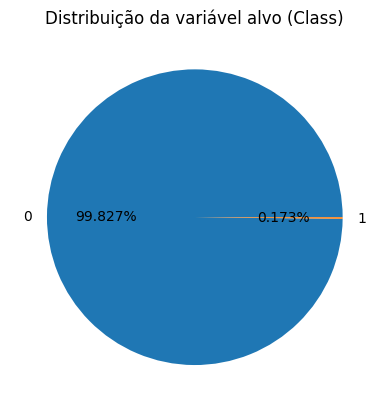

In [3]:
# Classes distintas e contagem de cada classe
labels = raw_data["Class"].unique()
sizes = raw_data["Class"].value_counts().values

# Gráfico de pizza com a distribuição das classes
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title("Distribuição da variável alvo (Class)")
plt.show()


É esperado que **fraudes (1)** sejam uma **minoria**.

👉 Isso é importante porque:
- a **acurácia** pode enganar em dados desbalanceados;
- uma técnica simples é usar **pesos** para dar mais importância à classe minoritária durante o treino.


### 3.2. Correlação simples com o alvo

Uma forma rápida (não perfeita) de “sentir” quais features têm relação com o alvo é olhar a correlação com **Class**.


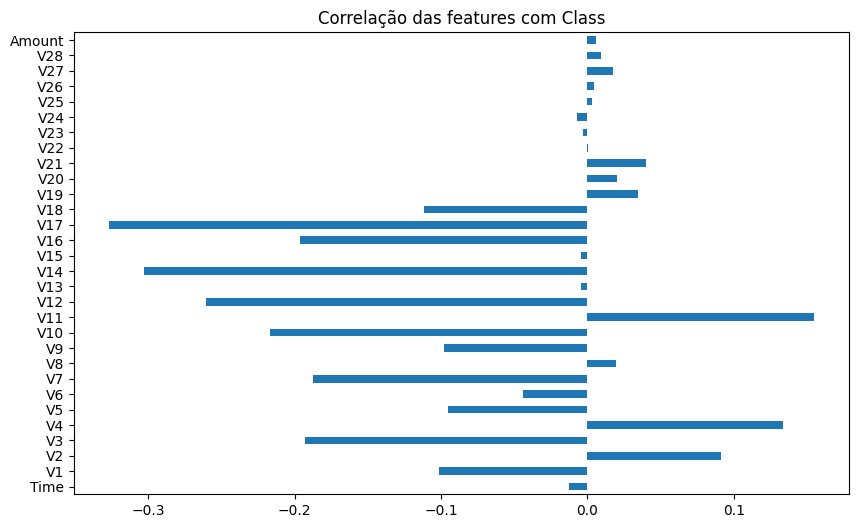

In [4]:
# Correlação (Pearson) de cada feature com o alvo (Class)
correlation_values = raw_data.corr(numeric_only=True)["Class"].drop("Class")

# Visualização
correlation_values.plot(kind="barh", figsize=(10, 6))
plt.title("Correlação das features com Class")
plt.show()


Se algumas features têm correlação absoluta maior com **Class**, pode fazer sentido testar **seleção de features** para comparar desempenho (veremos isso nos exercícios).


## 4. Pré-processamento


Vamos preparar os dados para treinar os modelos.

O que vamos fazer:

1. **Padronizar** as features (tirar média e dividir pelo desvio padrão) com `StandardScaler`  
2. **Normalizar** com norma **L1** (`normalize(..., norm="l1")`)  
3. **Excluir** a coluna `Time` (ela não será usada como feature aqui)

In [5]:
# 1) Padronização (z-score) das features: V1..V28 e Amount (exclui Time e Class)
raw_data_scaled = raw_data.copy()
raw_data_scaled.iloc[:, 1:30] = StandardScaler().fit_transform(raw_data_scaled.iloc[:, 1:30])

# Transformar em matriz NumPy
data_matrix = raw_data_scaled.values

# 2) Matriz de features X: colunas 1..29 (exclui Time)
X = data_matrix[:, 1:30]

# 3) Vetor alvo y: coluna 30 (Class)
y = data_matrix[:, 30]

# 4) Normalização L1 (ajuda alguns modelos a convergirem melhor)
X = normalize(X, norm="l1")

X.shape, y.shape


((284807, 29), (284807,))

## 5. Divisão treino/teste


Separamos parte dos dados para **treinar** e parte para **testar**.

- `test_size=0.3` → 30% para teste
- `random_state` → reprodutibilidade


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape

((199364, 29), (85443, 29))

## 6. Modelo 1 — Árvore de Decisão (Scikit-Learn)


Como o dataset é desbalanceado, vamos calcular **pesos de amostra** para o treino, para que a árvore “preste mais atenção” nas fraudes.


In [7]:
# Pesos para compensar o desbalanceamento (classe minoritária recebe peso maior)
w_train = compute_sample_weight(class_weight="balanced", y=y_train)

# Criar e treinar o modelo (limitamos a profundidade para reduzir overfitting)
dt = DecisionTreeClassifier(max_depth=4, random_state=35)
dt.fit(X_train, y_train, sample_weight=w_train)


DecisionTreeClassifier(max_depth=4, random_state=35)

## 7. Modelo 2 — SVM Linear (Scikit-Learn)


No `scikit-learn`, podemos lidar com desbalanceamento no SVM usando `class_weight="balanced"`.

O `LinearSVC` não devolve probabilidades por padrão, mas fornece `decision_function`, que é uma **pontuação** (distância ao hiperplano).  
Essa pontuação funciona bem para métricas como **ROC-AUC**.


In [8]:
svm = LinearSVC(
    class_weight="balanced",
    random_state=31,
    loss="hinge",
    fit_intercept=False
)

svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

## 8. Avaliação — ROC-AUC


### 8.1. ROC-AUC para Árvore de Decisão

A **ROC-AUC** mede quão bem o modelo separa as classes (0 vs 1) considerando *todos* os limiares possíveis.  
Quanto maior, melhor (em geral).


In [9]:
# Probabilidade prevista de ser fraude (classe 1)
y_score_dt = dt.predict_proba(X_test)[:, 1]

roc_auc_dt = roc_auc_score(y_test, y_score_dt)
print(f"ROC-AUC (Decision Tree): {roc_auc_dt:.3f}")


ROC-AUC (Decision Tree): 0.939


### 8.2) ROC-AUC para SVM


In [10]:
# Pontuação (distância ao hiperplano) — serve como "score" para ROC-AUC
y_score_svm = svm.decision_function(X_test)

roc_auc_svm = roc_auc_score(y_test, y_score_svm)
print(f"ROC-AUC (SVM): {roc_auc_svm:.3f}")


ROC-AUC (SVM): 0.986


## 9. Exercícios


Vamos testar **seleção de features**: usar apenas as features mais correlacionadas com `Class`.

**Perguntas:**
1. Quais são as 6 features com maior correlação absoluta com `Class`?
2. Como muda o ROC-AUC da Árvore de Decisão ao usar só essas 6?
3. Como muda o ROC-AUC do SVM ao usar só essas 6?


In [11]:
# 1) Top-6 features por correlação absoluta com Class
top_corr = abs(raw_data.corr(numeric_only=True)["Class"]).drop("Class").sort_values(ascending=False).head(6)
top_corr

,Class
V17,0.326481
V14,0.302544
V12,0.260593
V10,0.216883
V16,0.196539
V3,0.192961


In [12]:
# Índices dessas features na matriz original (0=Time, 1=V1, 2=V2, ..., 29=Amount, 30=Class)
feature_cols_top6 = [3, 10, 12, 14, 16, 17]

In [13]:
def preparar_X_y(raw_df: pd.DataFrame, feature_cols: list[int]):
    df = raw_df.copy()
    df.iloc[:, 1:30] = StandardScaler().fit_transform(df.iloc[:, 1:30])
    mat = df.values

    X_local = mat[:, feature_cols]
    y_local = mat[:, 30]
    X_local = normalize(X_local, norm="l1")
    return X_local, y_local


def treinar_e_avaliar(feature_cols: list[int], nome: str):
    X_local, y_local = preparar_X_y(raw_data, feature_cols)
    X_tr, X_te, y_tr, y_te = train_test_split(X_local, y_local, test_size=0.3, random_state=42)

    # Árvore com pesos por amostra
    w_tr = compute_sample_weight(class_weight="balanced", y=y_tr)
    dt_local = DecisionTreeClassifier(max_depth=4, random_state=35)
    dt_local.fit(X_tr, y_tr, sample_weight=w_tr)
    auc_dt = roc_auc_score(y_te, dt_local.predict_proba(X_te)[:, 1])

    # SVM com peso de classe
    svm_local = LinearSVC(class_weight="balanced", random_state=31, loss="hinge", fit_intercept=False)
    svm_local.fit(X_tr, y_tr)
    auc_svm = roc_auc_score(y_te, svm_local.decision_function(X_te))

    print(f"[{nome}] ROC-AUC DT = {auc_dt:.3f} | ROC-AUC SVM = {auc_svm:.3f}")
    return auc_dt, auc_svm


In [14]:
# Comparação: todas as features vs. top-6
# Todas as features: colunas 1..29 (V1..Amount)
feature_cols_all = list(range(1, 30))

auc_all = treinar_e_avaliar(feature_cols_all, "Todas as features (30)")
auc_top = treinar_e_avaliar(feature_cols_top6, "Top-6 por correlação")


[Todas as features (30)] ROC-AUC DT = 0.939 | ROC-AUC SVM = 0.986
[Top-6 por correlação] ROC-AUC DT = 0.952 | ROC-AUC SVM = 0.937


### 9.1. Interpretação

- **Árvore de decisão** pode **melhorar** com seleção de features (menos ruído → divisão mais “limpa”).
- **SVM linear** às vezes **piora** ao reduzir dimensionalidade, porque pode precisar de mais features para separar bem as classes com um hiperplano.

O ponto principal: **o melhor conjunto de features depende do modelo** e do padrão nos dados.
